In [13]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Travel times to cities

* Take collection of randomly placed points and interpolate grid using z index
* Large regions without points need to be removed using a distance function
    * How do we determine what the distance threshold should be?
* This can be used to generate tiles for HiGlass

### Load the data and inspect

In [14]:
import pandas as pd

t1 = pd.read_table('../data/world.csv.gz', delimiter=',')

# sub-sample a portion of the points to speed up testing,
# the complete version will use the whole point set

#t = t1.sample(1000000)
t = t1

t.head()

/Users/pete/miniconda3/envs/cenv4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,lat,lon,poi_town,admin_area
0,9999765,15.23850,-23.21325,1025.615690,Africa
1,9999766,15.30073,-23.19242,4514.848251,Africa
2,9999767,15.12082,-23.18732,2546.846200,Africa
3,9999768,15.27154,-23.23572,3484.165707,Africa
4,9999769,15.17577,-23.15718,1300.567389,Africa


### Project the coordinates to mercator

In [15]:
# mercator projection function
import math
import numpy as np

def lat2y(a):
  return 180.0/math.pi*np.log(np.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))

In [16]:
import zindex.zindex as zz

t['x'] = t['lon']
t['y'] = lat2y(t['lat'])


### Sort by z-index

The point set is currently not sorted. We're going to place the points
on a 2^32 by 2^32 grid and sort them by z-order (Morton curve). This
will preserve spatial locality in the ordering and make it easy to use
these points for value interpolation in the future.

In [17]:
points = np.array([t['x'], t['y']]).T
bounds = [-180, -180, 180, 180]
zoom = 32    # the maximum zoom level that we can use with 64 bit integers
(sorted_points, sorted_interleaved, sort_order) = zz.sort_points(points, bounds, 32)
sorted_poi = t['poi_town'].values[sort_order]

### Store as HDF5

To reuse these points in the future, we will store them in an hdf file.

In [18]:
import h5py
import os
import os.path as op

filename = '../data/points.hdf5'

if op.exists(filename):
    os.remove(filename)

with h5py.File(filename, 'w') as f:
    f.create_dataset('interleaved', data=sorted_interleaved)
    f.create_dataset('values', data=sorted_poi)
    f.create_dataset('sorted_points', data=sorted_points)

In [19]:
tile_width = (bounds[2] - bounds[0]) / 2 ** zoom
float_points = (points - bounds[0]) // tile_width
print("tile_width:", tile_width)

tile_width: 8.381903171539307e-08


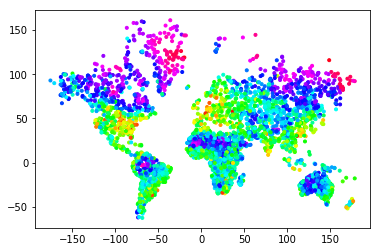

In [20]:
indeces = np.random.choice(range(len(t['x'])), 4000)
rand = np.array([t['x'], t['y'], np.log(t['poi_town'])]).T[indeces]
#indeces = np.random.choice(range(len(sorted_points)), 8000)
#rand = np.array([sorted_points[:,0], sorted_points[:,1], sorted_interleaved]).T[indeces]
x = rand[:,2][:]
import matplotlib.pyplot as plt

plt.scatter(rand[:,0], rand[:,1], c=x, marker='.', cmap='hsv')
plt.show()

## Nearest neighbor

In [21]:
%%time

def nn_interpolate(sorted_interleaved, region_bounds, 
                  global_bounds, width, zoom=32):
    tile_width = (global_bounds[2] - global_bounds[0]) / 2 ** zoom

    xmin = region_bounds[0]
    xmax = region_bounds[2]
    ymin = region_bounds[1]
    ymax = region_bounds[3]
    
    X, Y = np.mgrid[xmin:xmax:complex(0,width), ymin:ymax:complex(0,width)]
    
    positions = np.vstack([X.ravel(), Y.ravel()]).T
    int_points = ((positions - global_bounds[0]) // tile_width).astype(np.uint64)
    
    to_return = []
    for pos in positions:
        nn = zz.nearest_neighbor(pos, sorted_interleaved, global_bounds, zoom)
        # print("nn", nn)
        to_return += [nn[0]]
        
    #x = zz.neire(int_points[:,0][:], int_points[:,1][:])  

    # print(positions[:10])

    # indeces = np.searchsorted(sorted_interleaved, x)
    # points = ordered_points[indeces[indeces < len(ordered_points)]]
    # fpositions = positions[indeces < len(ordered_points)]
    
    return to_return
bounds = [-180, -180, 179.9, 179.9]

nn_interpolate(sorted_interleaved, bounds, bounds, 10, zoom=32)

CPU times: user 595 ms, sys: 4.25 ms, total: 599 ms
Wall time: 599 ms


## Z-Index based interpolation

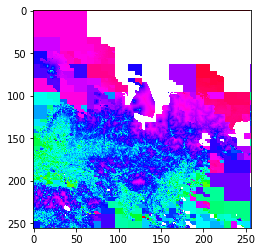

CPU times: user 438 ms, sys: 185 ms, total: 623 ms
Wall time: 460 ms


In [34]:
%%time

import zindex.zindex as zz

def tile_data(z, x, y, tile_pixels=256):
    '''
    Get interpolated values for a tile as defined by the 
    zoom level (z), x position (x), y position (y) and 
    '''
    tile_width = 360 / 2 ** z    
    tile_x = -180 + x * tile_width
    tile_y = 180 - (y + 1) * tile_width
    
    bounds = [tile_x, tile_y, 
              tile_x + tile_width, 
              tile_y + tile_width]
    
    f = h5py.File('../data/points.hdf5', 'r')
    sorted_interleaved = f['interleaved']
    sorted_points = f['sorted_points'][:]
    sorted_poi = f['values'][:]
    
    (ixs, positions) = zz.interpolate(
        f['interleaved'],
        region_bounds=bounds,
        global_bounds=[-180,-180,180,180],
        width=tile_pixels, 
        height=tile_pixels
    )
    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1
    
    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)
    new_array = sorted_poi[ixs]
    # new_array[residuals > 2] = np.nan

    mat = new_array.reshape((tile_pixels,tile_pixels))
        
    return mat.T.copy(order='C')

mat = tile_data(1,1,0)
plt.imshow(np.log(mat), cmap='hsv')
plt.show()

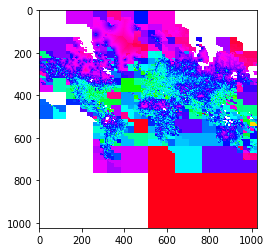

CPU times: user 985 ms, sys: 249 ms, total: 1.23 s
Wall time: 1.06 s


In [23]:
%%time

mat = tile_data(0,0,0, tile_pixels=256 * 2 ** 2)
plt.imshow(np.log(mat), cmap='hsv')
plt.show()

In [35]:
%%time

import h5py
import os
import os.path as op

filename = '../data/int_matrices.hdf5'

if op.exists(filename):
    os.remove(filename)

max_zoom = 6

with h5py.File(filename, 'w') as f:
    f.attrs['max-zoom'] = max_zoom
    f.attrs['min-pos'] = [-180, -180]
    f.attrs['max-pos'] = [180, 180]
    
    for i in range(max_zoom+1):
        mat = tile_data(0,0,0, tile_pixels=256 * 2 ** (i))
        print("i:", i)
        f.create_dataset('resolutions/{}'.format(2**(max_zoom - i)), data=mat, compression='gzip')

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
CPU times: user 3min 41s, sys: 2min 51s, total: 6min 33s
Wall time: 13min 44s


## Tiles and server

In [231]:
import numpy as np
import h5py
import zindex.zindex as zz
import matplotlib.pyplot as plt

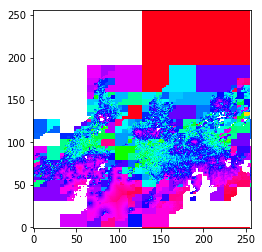

In [30]:

import zindex.zindex as zz

def tile_data(z, x, y, width=1, height=1, tile_pixels=256):
    '''
    Get interpolated values for a tile as defined by the 
    zoom level (z), x position (x), y position (y) and 
    '''
    tile_width = 360 / 2 ** z    
    tile_x = -180 + x * tile_width
    tile_y = 180 - (y + height) * tile_width
    
    bounds = [tile_x, tile_y, 
              tile_x + width * tile_width, 
              tile_y + height * tile_width]
    
    f = h5py.File('../data/points.hdf5', 'r')
    
    sorted_interleaved = f['interleaved']
    sorted_points = f['sorted_points'][:]
    sorted_poi = f['values'][:]
    
    (ixs, positions) = zz.interpolate(
        f['interleaved'],
        region_bounds=bounds,
        global_bounds=[-180,-180,180,180],
        width=tile_pixels * width, 
        height=tile_pixels * height
    )
    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1
    
    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)
    new_array = sorted_poi[ixs]
    # new_array[residuals > 2] = np.nan

    mat = new_array.reshape((tile_pixels*width,tile_pixels*height))
    
    tiles = []
    
    mat = mat.T.copy(order='C')
    for i in range(width):
        for j in range(height):
            tiles += [((z,x+i,y+j), 
                       mat[j*tile_pixels:(j+1) * tile_pixels,
                           i*tile_pixels:(i+1) * tile_pixels])]
            
    
    return tiles

mat = tile_data(0,0,0)
#print("mat:", mat)
plt.imshow(np.log(mat[0][1]), origin='lower', cmap='hsv')
plt.show()

In [317]:
"""
import zindex.zindex as zz

def tile_data(z, x, y):
    '''
    Get interpolated values for a tile as defined by the 
    zoom level (z), x position (x), y position (y) and 
    '''
    tile_width = 360 / 2 ** z    
    tile_x = -180 + x * tile_width
    tile_y = 180 - (y + 1) * tile_width
    
    bounds = [tile_x, tile_y, 
              tile_x + tile_width, 
              tile_y + tile_width]
    
    f = h5py.File('../data/points.hdf5', 'r')
    tile_pixels = 256
    sorted_interleaved = f['interleaved']
    sorted_points = f['sorted_points'][:]
    sorted_poi = f['values'][:]
    
    (ixs, positions) = zz.interpolate(
        f['interleaved'],
        region_bounds=bounds,
        global_bounds=[-180,-180,180,180],
        width=tile_pixels, 
        height=tile_pixels
    )
    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1
    
    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)
    new_array = sorted_poi[ixs]
    # new_array[residuals > 2] = np.nan

    mat = new_array.reshape((tile_pixels,tile_pixels))
        
    return mat.T.copy(order='C')            

mat = tile_data(1,0,0)
#print("mat:", mat)
plt.imshow(np.log(mat), origin='lower', cmap='hsv')
plt.show()"""

'\nimport zindex.zindex as zz\n\ndef tile_data(z, x, y):\n    \'\'\'\n    Get interpolated values for a tile as defined by the \n    zoom level (z), x position (x), y position (y) and \n    \'\'\'\n    tile_width = 360 / 2 ** z    \n    tile_x = -180 + x * tile_width\n    tile_y = 180 - (y + 1) * tile_width\n    \n    bounds = [tile_x, tile_y, \n              tile_x + tile_width, \n              tile_y + tile_width]\n    \n    f = h5py.File(\'../data/points.hdf5\', \'r\')\n    tile_pixels = 256\n    sorted_interleaved = f[\'interleaved\']\n    sorted_points = f[\'sorted_points\'][:]\n    sorted_poi = f[\'values\'][:]\n    \n    (ixs, positions) = zz.interpolate(\n        f[\'interleaved\'],\n        region_bounds=bounds,\n        global_bounds=[-180,-180,180,180],\n        width=tile_pixels, \n        height=tile_pixels\n    )\n    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1\n    \n    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)\n    new_array 

In [334]:
def tileset_info():
    return {
        'min_pos': [-180, -180],
        'max_pos': [180, 180],
        'max_width': 360,
        'max_zoom': 8,
        'mirror_tiles': 'false',
        'bins_per_dimension': 256,
    }

In [335]:
# f = lambda z,x,y: ((z,x,y), hgfo.format_dense_tile(tile_data(z, x, y)))
# f(0,0,0)

In [336]:
import hgflask.server as hgse
import hgflask.tilesets as hfti
import hgtiles.format as hgfo
import hgtiles.utils as hgut
    
ts = hfti.Tileset(
    tileset_info=tileset_info,
    tiles=lambda tile_ids: 
        hgut.bundled_tiles_wrapper_2d(tile_ids,
            lambda z,x,y,width=1,height=1: 
                [(tile_id, hgfo.format_dense_tile(tile)) for 
                  (tile_id, tile) in tile_data(z, x, y, width, height)]))
server = hgse.start([ts])

terminating: EEFuKcWzR3iYuUvmyJIBGQ
sleeping


 * Running on http://0.0.0.0:51952/ (Press CTRL+C to quit)


sleeping


127.0.0.1 - - [09/Nov/2018 19:22:24] "GET /api/v1/tileset_info/?d=a HTTP/1.1" 200 -


ret: 200 b'{\n  "a": {\n    "error": "No such tileset with uid: a"\n  }\n}\n'
returning
tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.4.5']


127.0.0.1 - - [09/Nov/2018 19:22:24] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.4.5 HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:25] "OPTIONS /api/v1/tileset_info/?d=bB3BNSVmQQeALLZNieKIDQ&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:25] "GET /api/v1/tileset_info/?d=bB3BNSVmQQeALLZNieKIDQ&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:26] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.5&d=bB3BNSVmQQeALLZNieKIDQ.3.4.6&d=bB3BNSVmQQeALLZNieKIDQ.3.5.4&d=bB3BNSVmQQeALLZNieKIDQ.3.5.5&d=bB3BNSVmQQeALLZNieKIDQ.3.5.6&d=bB3BNSVmQQeALLZNieKIDQ.3.6.4&d=bB3BNSVmQQeALLZNieKIDQ.3.6.5&d=bB3BNSVmQQeALLZNieKIDQ.3.6.6&d=bB3BNSVmQQeALLZNieKIDQ.1.0.0&d=bB3BNSVmQQeALLZNieKIDQ.1.0.1&d=bB3BNSVmQQeALLZNieKIDQ.1.1.0&d=bB3BNSVmQQeALLZNieKIDQ.1.1.1&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.1.0.0', 'bB3BNSVmQQeALLZNieKIDQ.1.0.1', 'bB3BNSVmQQeALLZNieKIDQ.1.1.0', 'bB3BNSVmQQeALLZNieKIDQ.1.1.1']
tile_group: ['bB3BNSVmQQeALLZNieKIDQ.3.4.4', 'bB3BNSVmQQeALLZNieKIDQ.3.4.5', 'bB3BNSVmQQeALLZNieKIDQ.3.4.6', 'bB3BNSVmQQeALLZNieKIDQ.3.5.4', 'bB3BNSVmQQeALLZNieKIDQ.3.5.5', 'bB3BNSVmQQeALLZNieKIDQ.3.5.6', 'bB3BNSVmQQeALLZNieKIDQ.3.6.4', 'bB3BNSVmQQeALLZNieKIDQ.3.6.5', 'bB3BNSVmQQeALLZNieKIDQ.3.6.6']


127.0.0.1 - - [09/Nov/2018 19:22:27] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.5&d=bB3BNSVmQQeALLZNieKIDQ.3.4.6&d=bB3BNSVmQQeALLZNieKIDQ.3.5.4&d=bB3BNSVmQQeALLZNieKIDQ.3.5.5&d=bB3BNSVmQQeALLZNieKIDQ.3.5.6&d=bB3BNSVmQQeALLZNieKIDQ.3.6.4&d=bB3BNSVmQQeALLZNieKIDQ.3.6.5&d=bB3BNSVmQQeALLZNieKIDQ.3.6.6&d=bB3BNSVmQQeALLZNieKIDQ.1.0.0&d=bB3BNSVmQQeALLZNieKIDQ.1.0.1&d=bB3BNSVmQQeALLZNieKIDQ.1.1.0&d=bB3BNSVmQQeALLZNieKIDQ.1.1.1&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:45] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.2.1.0&d=bB3BNSVmQQeALLZNieKIDQ.2.1.1&d=bB3BNSVmQQeALLZNieKIDQ.2.1.2&d=bB3BNSVmQQeALLZNieKIDQ.2.2.0&d=bB3BNSVmQQeALLZNieKIDQ.2.2.1&d=bB3BNSVmQQeALLZNieKIDQ.2.2.2&d=bB3BNSVmQQeALLZNieKIDQ.2.3.0&d=bB3BNSVmQQeALLZNieKIDQ.2.3.1&d=bB3BNSVmQQeALLZNieKIDQ.2.3.2&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.2.1.0', 'bB3BNSVmQQeALLZNieKIDQ.2.1.1', 'bB3BNSVmQQeALLZNieKIDQ.2.1.2', 'bB3BNSVmQQeALLZNieKIDQ.2.2.0', 'bB3BNSVmQQeALLZNieKIDQ.2.2.1', 'bB3BNSVmQQeALLZNieKIDQ.2.2.2', 'bB3BNSVmQQeALLZNieKIDQ.2.3.0', 'bB3BNSVmQQeALLZNieKIDQ.2.3.1', 'bB3BNSVmQQeALLZNieKIDQ.2.3.2']


127.0.0.1 - - [09/Nov/2018 19:22:46] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.3.2&d=bB3BNSVmQQeALLZNieKIDQ.3.3.3&d=bB3BNSVmQQeALLZNieKIDQ.3.3.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.2&d=bB3BNSVmQQeALLZNieKIDQ.3.4.3&d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&d=bB3BNSVmQQeALLZNieKIDQ.3.5.2&d=bB3BNSVmQQeALLZNieKIDQ.3.5.3&d=bB3BNSVmQQeALLZNieKIDQ.3.5.4&d=bB3BNSVmQQeALLZNieKIDQ.3.6.2&d=bB3BNSVmQQeALLZNieKIDQ.3.6.3&d=bB3BNSVmQQeALLZNieKIDQ.3.6.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.3.3.2', 'bB3BNSVmQQeALLZNieKIDQ.3.3.3', 'bB3BNSVmQQeALLZNieKIDQ.3.3.4', 'bB3BNSVmQQeALLZNieKIDQ.3.4.2', 'bB3BNSVmQQeALLZNieKIDQ.3.4.3', 'bB3BNSVmQQeALLZNieKIDQ.3.4.4', 'bB3BNSVmQQeALLZNieKIDQ.3.5.2', 'bB3BNSVmQQeALLZNieKIDQ.3.5.3', 'bB3BNSVmQQeALLZNieKIDQ.3.5.4', 'bB3BNSVmQQeALLZNieKIDQ.3.6.2', 'bB3BNSVmQQeALLZNieKIDQ.3.6.3', 'bB3BNSVmQQeALLZNieKIDQ.3.6.4']


127.0.0.1 - - [09/Nov/2018 19:22:47] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.2.1.0&d=bB3BNSVmQQeALLZNieKIDQ.2.1.1&d=bB3BNSVmQQeALLZNieKIDQ.2.1.2&d=bB3BNSVmQQeALLZNieKIDQ.2.2.0&d=bB3BNSVmQQeALLZNieKIDQ.2.2.1&d=bB3BNSVmQQeALLZNieKIDQ.2.2.2&d=bB3BNSVmQQeALLZNieKIDQ.2.3.0&d=bB3BNSVmQQeALLZNieKIDQ.2.3.1&d=bB3BNSVmQQeALLZNieKIDQ.2.3.2&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:48] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.3.2&d=bB3BNSVmQQeALLZNieKIDQ.3.3.3&d=bB3BNSVmQQeALLZNieKIDQ.3.3.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.2&d=bB3BNSVmQQeALLZNieKIDQ.3.4.3&d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&d=bB3BNSVmQQeALLZNieKIDQ.3.5.2&d=bB3BNSVmQQeALLZNieKIDQ.3.5.3&d=bB3BNSVmQQeALLZNieKIDQ.3.5.4&d=bB3BNSVmQQeALLZNieKIDQ.3.6.2&d=bB3BNSVmQQeALLZNieKIDQ.3.6.3&d=bB3BNSVmQQeALLZNieKIDQ.3.6.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:51] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5

tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.5', 'bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.5', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6', 'bB3BNSVmQQeALLZNieKIDQ.4.9.5', 'bB3BNSVmQQeALLZNieKIDQ.4.9.6']


127.0.0.1 - - [09/Nov/2018 19:22:52] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:22:57] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11', 'bB3BNSVmQQeALLZNieKIDQ.5.15.12', 'bB3BNSVmQQeALLZNieKIDQ.5.16.10', 'bB3BNSVmQQeALLZNieKIDQ.5.16.11', 'bB3BNSVmQQeALLZNieKIDQ.5.16.12', 'bB3BNSVmQQeALLZNieKIDQ.5.17.10', 'bB3BNSVmQQeALLZNieKIDQ.5.17.11', 'bB3BNSVmQQeALLZNieKIDQ.5.17.12']


127.0.0.1 - - [09/Nov/2018 19:22:58] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:23:02] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.31.21&d=bB3BNSVmQQeALLZNieKIDQ.6.31.22&d=bB3BNSVmQQeALLZNieKIDQ.6.31.23&d=bB3BNSVmQQeALLZNieKIDQ.6.32.21&d=bB3BNSVmQQeALLZNieKIDQ.6.32.22&d=bB3BNSVmQQeALLZNieKIDQ.6.32.23&d=bB3BNSVmQQeALLZNieKIDQ.6.33.21&d=bB3BNSVmQQeALLZNieKIDQ.6.33.22&d=bB3BNSVmQQeALLZNieKIDQ.6.33.23&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.6.31.21', 'bB3BNSVmQQeALLZNieKIDQ.6.31.22', 'bB3BNSVmQQeALLZNieKIDQ.6.31.23', 'bB3BNSVmQQeALLZNieKIDQ.6.32.21', 'bB3BNSVmQQeALLZNieKIDQ.6.32.22', 'bB3BNSVmQQeALLZNieKIDQ.6.32.23', 'bB3BNSVmQQeALLZNieKIDQ.6.33.21', 'bB3BNSVmQQeALLZNieKIDQ.6.33.22', 'bB3BNSVmQQeALLZNieKIDQ.6.33.23']


127.0.0.1 - - [09/Nov/2018 19:23:03] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.31.21&d=bB3BNSVmQQeALLZNieKIDQ.6.31.22&d=bB3BNSVmQQeALLZNieKIDQ.6.31.23&d=bB3BNSVmQQeALLZNieKIDQ.6.32.21&d=bB3BNSVmQQeALLZNieKIDQ.6.32.22&d=bB3BNSVmQQeALLZNieKIDQ.6.32.23&d=bB3BNSVmQQeALLZNieKIDQ.6.33.21&d=bB3BNSVmQQeALLZNieKIDQ.6.33.22&d=bB3BNSVmQQeALLZNieKIDQ.6.33.23&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:38] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11', 'bB3BNSVmQQeALLZNieKIDQ.5.15.12', 'bB3BNSVmQQeALLZNieKIDQ.5.16.10', 'bB3BNSVmQQeALLZNieKIDQ.5.16.11', 'bB3BNSVmQQeALLZNieKIDQ.5.16.12']


127.0.0.1 - - [09/Nov/2018 19:54:39] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:44] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.13&d=bB3BNSVmQQeALLZNieKIDQ.5.16.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.13', 'bB3BNSVmQQeALLZNieKIDQ.5.16.13']


127.0.0.1 - - [09/Nov/2018 19:54:45] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.13&d=bB3BNSVmQQeALLZNieKIDQ.5.16.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:50] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.16.10', 'bB3BNSVmQQeALLZNieKIDQ.5.17.10', 'bB3BNSVmQQeALLZNieKIDQ.5.17.11']


127.0.0.1 - - [09/Nov/2018 19:54:50] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:53] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.16.12', 'bB3BNSVmQQeALLZNieKIDQ.5.17.12']


127.0.0.1 - - [09/Nov/2018 19:54:53] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:55] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11']


127.0.0.1 - - [09/Nov/2018 19:54:55] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:54:59] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.32.20&d=bB3BNSVmQQeALLZNieKIDQ.6.32.21&d=bB3BNSVmQQeALLZNieKIDQ.6.32.22&d=bB3BNSVmQQeALLZNieKIDQ.6.33.20&d=bB3BNSVmQQeALLZNieKIDQ.6.33.21&d=bB3BNSVmQQeALLZNieKIDQ.6.33.22&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.6.32.20', 'bB3BNSVmQQeALLZNieKIDQ.6.32.21', 'bB3BNSVmQQeALLZNieKIDQ.6.32.22', 'bB3BNSVmQQeALLZNieKIDQ.6.33.20', 'bB3BNSVmQQeALLZNieKIDQ.6.33.21', 'bB3BNSVmQQeALLZNieKIDQ.6.33.22']


127.0.0.1 - - [09/Nov/2018 19:54:59] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.32.20&d=bB3BNSVmQQeALLZNieKIDQ.6.32.21&d=bB3BNSVmQQeALLZNieKIDQ.6.32.22&d=bB3BNSVmQQeALLZNieKIDQ.6.33.20&d=bB3BNSVmQQeALLZNieKIDQ.6.33.21&d=bB3BNSVmQQeALLZNieKIDQ.6.33.22&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:01] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11', 'bB3BNSVmQQeALLZNieKIDQ.5.16.10', 'bB3BNSVmQQeALLZNieKIDQ.5.16.11', 'bB3BNSVmQQeALLZNieKIDQ.5.17.10', 'bB3BNSVmQQeALLZNieKIDQ.5.17.11']


127.0.0.1 - - [09/Nov/2018 19:55:02] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:04] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.12', 'bB3BNSVmQQeALLZNieKIDQ.5.16.12', 'bB3BNSVmQQeALLZNieKIDQ.5.17.12']


127.0.0.1 - - [09/Nov/2018 19:55:04] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:05] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.10&d=bB3BNSVmQQeALLZNieKIDQ.5.18.11&d=bB3BNSVmQQeALLZNieKIDQ.5.18.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.18.10', 'bB3BNSVmQQeALLZNieKIDQ.5.18.11', 'bB3BNSVmQQeALLZNieKIDQ.5.18.12']


127.0.0.1 - - [09/Nov/2018 19:55:05] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.10&d=bB3BNSVmQQeALLZNieKIDQ.5.18.11&d=bB3BNSVmQQeALLZNieKIDQ.5.18.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:08] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.19.11&d=bB3BNSVmQQeALLZNieKIDQ.5.19.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.19.11', 'bB3BNSVmQQeALLZNieKIDQ.5.19.12']


127.0.0.1 - - [09/Nov/2018 19:55:09] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.19.11&d=bB3BNSVmQQeALLZNieKIDQ.5.19.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:11] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.13&d=bB3BNSVmQQeALLZNieKIDQ.5.19.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.18.13', 'bB3BNSVmQQeALLZNieKIDQ.5.19.13']


127.0.0.1 - - [09/Nov/2018 19:55:11] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.13&d=bB3BNSVmQQeALLZNieKIDQ.5.19.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:13] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.17.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.17.13']


127.0.0.1 - - [09/Nov/2018 19:55:13] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.17.13&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:15] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.10.5&d=bB3BNSVmQQeALLZNieKIDQ.4.10.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.8.5', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6', 'bB3BNSVmQQeALLZNieKIDQ.4.9.5', 'bB3BNSVmQQeALLZNieKIDQ.4.9.6', 'bB3BNSVmQQeALLZNieKIDQ.4.10.5', 'bB3BNSVmQQeALLZNieKIDQ.4.10.6']


127.0.0.1 - - [09/Nov/2018 19:55:16] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.10.5&d=bB3BNSVmQQeALLZNieKIDQ.4.10.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:18] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.4&d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.4&d=bB3BNSVmQQeALLZNieKIDQ.4.9.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.4', 'bB3BNSVmQQeALLZNieKIDQ.4.7.5', 'bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.4', 'bB3BNSVmQQeALLZNieKIDQ.4.9.4']


127.0.0.1 - - [09/Nov/2018 19:55:19] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.4&d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.4&d=bB3BNSVmQQeALLZNieKIDQ.4.9.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:28] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6']


127.0.0.1 - - [09/Nov/2018 19:55:29] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:31] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6']


127.0.0.1 - - [09/Nov/2018 19:55:31] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:33] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11', 'bB3BNSVmQQeALLZNieKIDQ.5.15.12', 'bB3BNSVmQQeALLZNieKIDQ.5.16.10', 'bB3BNSVmQQeALLZNieKIDQ.5.16.11', 'bB3BNSVmQQeALLZNieKIDQ.5.16.12', 'bB3BNSVmQQeALLZNieKIDQ.5.17.10', 'bB3BNSVmQQeALLZNieKIDQ.5.17.11', 'bB3BNSVmQQeALLZNieKIDQ.5.17.12']


127.0.0.1 - - [09/Nov/2018 19:55:34] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.10&d=bB3BNSVmQQeALLZNieKIDQ.5.16.11&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.10&d=bB3BNSVmQQeALLZNieKIDQ.5.17.11&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:40] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11']


127.0.0.1 - - [09/Nov/2018 19:55:41] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:41] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.9&d=bB3BNSVmQQeALLZNieKIDQ.5.16.9&d=bB3BNSVmQQeALLZNieKIDQ.5.17.9&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.9', 'bB3BNSVmQQeALLZNieKIDQ.5.16.9', 'bB3BNSVmQQeALLZNieKIDQ.5.17.9']


127.0.0.1 - - [09/Nov/2018 19:55:41] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.9&d=bB3BNSVmQQeALLZNieKIDQ.5.16.9&d=bB3BNSVmQQeALLZNieKIDQ.5.17.9&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:41] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.10&d=bB3BNSVmQQeALLZNieKIDQ.5.18.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.18.10', 'bB3BNSVmQQeALLZNieKIDQ.5.18.11']


127.0.0.1 - - [09/Nov/2018 19:55:42] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.18.10&d=bB3BNSVmQQeALLZNieKIDQ.5.18.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:48] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.10', 'bB3BNSVmQQeALLZNieKIDQ.5.15.11']


127.0.0.1 - - [09/Nov/2018 19:55:48] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.10&d=bB3BNSVmQQeALLZNieKIDQ.5.15.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:53] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.9&d=bB3BNSVmQQeALLZNieKIDQ.5.16.9&d=bB3BNSVmQQeALLZNieKIDQ.5.17.9&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.9', 'bB3BNSVmQQeALLZNieKIDQ.5.16.9', 'bB3BNSVmQQeALLZNieKIDQ.5.17.9']


127.0.0.1 - - [09/Nov/2018 19:55:54] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.9&d=bB3BNSVmQQeALLZNieKIDQ.5.16.9&d=bB3BNSVmQQeALLZNieKIDQ.5.17.9&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:56] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.14.9&d=bB3BNSVmQQeALLZNieKIDQ.5.14.10&d=bB3BNSVmQQeALLZNieKIDQ.5.14.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.14.9', 'bB3BNSVmQQeALLZNieKIDQ.5.14.10', 'bB3BNSVmQQeALLZNieKIDQ.5.14.11']


127.0.0.1 - - [09/Nov/2018 19:55:57] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.14.9&d=bB3BNSVmQQeALLZNieKIDQ.5.14.10&d=bB3BNSVmQQeALLZNieKIDQ.5.14.11&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:57] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.4&d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.4&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.4', 'bB3BNSVmQQeALLZNieKIDQ.4.7.5', 'bB3BNSVmQQeALLZNieKIDQ.4.8.4', 'bB3BNSVmQQeALLZNieKIDQ.4.8.5']


127.0.0.1 - - [09/Nov/2018 19:55:57] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.4&d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.4&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:55:59] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6']


127.0.0.1 - - [09/Nov/2018 19:56:00] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:56:03] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.7&d=bB3BNSVmQQeALLZNieKIDQ.4.8.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.7', 'bB3BNSVmQQeALLZNieKIDQ.4.8.7']


127.0.0.1 - - [09/Nov/2018 19:56:03] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.7&d=bB3BNSVmQQeALLZNieKIDQ.4.8.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:56:04] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.9.5', 'bB3BNSVmQQeALLZNieKIDQ.4.9.6', 'bB3BNSVmQQeALLZNieKIDQ.4.9.7']


127.0.0.1 - - [09/Nov/2018 19:56:05] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:56:29] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.3.2&d=bB3BNSVmQQeALLZNieKIDQ.3.3.3&d=bB3BNSVmQQeALLZNieKIDQ.3.3.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.2&d=bB3BNSVmQQeALLZNieKIDQ.3.4.3&d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.3.3.2', 'bB3BNSVmQQeALLZNieKIDQ.3.3.3', 'bB3BNSVmQQeALLZNieKIDQ.3.3.4', 'bB3BNSVmQQeALLZNieKIDQ.3.4.2', 'bB3BNSVmQQeALLZNieKIDQ.3.4.3', 'bB3BNSVmQQeALLZNieKIDQ.3.4.4']


127.0.0.1 - - [09/Nov/2018 19:56:30] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.3.3.2&d=bB3BNSVmQQeALLZNieKIDQ.3.3.3&d=bB3BNSVmQQeALLZNieKIDQ.3.3.4&d=bB3BNSVmQQeALLZNieKIDQ.3.4.2&d=bB3BNSVmQQeALLZNieKIDQ.3.4.3&d=bB3BNSVmQQeALLZNieKIDQ.3.4.4&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:56:31] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.7.7&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.7&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.7.7', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.7', 'bB3BNSVmQQeALLZNieKIDQ.4.9.6', 'bB3BNSVmQQeALLZNieKIDQ.4.9.7']


127.0.0.1 - - [09/Nov/2018 19:56:32] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.7.7&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.7&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:57:09] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.15.13&d=bB3BNSVmQQeALLZNieKIDQ.5.15.14&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.13&d=bB3BNSVmQQeALLZNieKIDQ.5.16.14&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.13&d=bB3BNSVmQQeALLZNieKIDQ.5.17.14&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.5.15.12', 'bB3BNSVmQQeALLZNieKIDQ.5.15.13', 'bB3BNSVmQQeALLZNieKIDQ.5.15.14', 'bB3BNSVmQQeALLZNieKIDQ.5.16.12', 'bB3BNSVmQQeALLZNieKIDQ.5.16.13', 'bB3BNSVmQQeALLZNieKIDQ.5.16.14', 'bB3BNSVmQQeALLZNieKIDQ.5.17.12', 'bB3BNSVmQQeALLZNieKIDQ.5.17.13', 'bB3BNSVmQQeALLZNieKIDQ.5.17.14']


127.0.0.1 - - [09/Nov/2018 19:57:10] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.31.26&d=bB3BNSVmQQeALLZNieKIDQ.6.31.27&d=bB3BNSVmQQeALLZNieKIDQ.6.31.28&d=bB3BNSVmQQeALLZNieKIDQ.6.32.26&d=bB3BNSVmQQeALLZNieKIDQ.6.32.27&d=bB3BNSVmQQeALLZNieKIDQ.6.32.28&d=bB3BNSVmQQeALLZNieKIDQ.6.33.26&d=bB3BNSVmQQeALLZNieKIDQ.6.33.27&d=bB3BNSVmQQeALLZNieKIDQ.6.33.28&d=bB3BNSVmQQeALLZNieKIDQ.6.34.26&d=bB3BNSVmQQeALLZNieKIDQ.6.34.27&d=bB3BNSVmQQeALLZNieKIDQ.6.34.28&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.6.31.26', 'bB3BNSVmQQeALLZNieKIDQ.6.31.27', 'bB3BNSVmQQeALLZNieKIDQ.6.31.28', 'bB3BNSVmQQeALLZNieKIDQ.6.32.26', 'bB3BNSVmQQeALLZNieKIDQ.6.32.27', 'bB3BNSVmQQeALLZNieKIDQ.6.32.28', 'bB3BNSVmQQeALLZNieKIDQ.6.33.26', 'bB3BNSVmQQeALLZNieKIDQ.6.33.27', 'bB3BNSVmQQeALLZNieKIDQ.6.33.28', 'bB3BNSVmQQeALLZNieKIDQ.6.34.26', 'bB3BNSVmQQeALLZNieKIDQ.6.34.27', 'bB3BNSVmQQeALLZNieKIDQ.6.34.28']


127.0.0.1 - - [09/Nov/2018 19:57:11] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.5.15.12&d=bB3BNSVmQQeALLZNieKIDQ.5.15.13&d=bB3BNSVmQQeALLZNieKIDQ.5.15.14&d=bB3BNSVmQQeALLZNieKIDQ.5.16.12&d=bB3BNSVmQQeALLZNieKIDQ.5.16.13&d=bB3BNSVmQQeALLZNieKIDQ.5.16.14&d=bB3BNSVmQQeALLZNieKIDQ.5.17.12&d=bB3BNSVmQQeALLZNieKIDQ.5.17.13&d=bB3BNSVmQQeALLZNieKIDQ.5.17.14&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:57:11] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.6.31.26&d=bB3BNSVmQQeALLZNieKIDQ.6.31.27&d=bB3BNSVmQQeALLZNieKIDQ.6.31.28&d=bB3BNSVmQQeALLZNieKIDQ.6.32.26&d=bB3BNSVmQQeALLZNieKIDQ.6.32.27&d=bB3BNSVmQQeALLZNieKIDQ.6.32.28&d=bB3BNSVmQQeALLZNieKIDQ.6.33.26&d=bB3BNSVmQQeALLZNieKIDQ.6.33.27&d=bB3BNSVmQQeALLZNieKIDQ.6.33.28&d=bB3BNSVmQQeALLZNieKIDQ.6.34.26&d=bB3BNSVmQQeALLZNieKIDQ.6.34.27&d=bB3BNSVmQQeALLZNieKIDQ.6.34.28&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:57:14] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNi

tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.6', 'bB3BNSVmQQeALLZNieKIDQ.4.7.7', 'bB3BNSVmQQeALLZNieKIDQ.4.8.6', 'bB3BNSVmQQeALLZNieKIDQ.4.8.7', 'bB3BNSVmQQeALLZNieKIDQ.4.9.6', 'bB3BNSVmQQeALLZNieKIDQ.4.9.7']


127.0.0.1 - - [09/Nov/2018 19:57:15] "OPTIONS /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


tile_group: ['bB3BNSVmQQeALLZNieKIDQ.4.7.5', 'bB3BNSVmQQeALLZNieKIDQ.4.8.5', 'bB3BNSVmQQeALLZNieKIDQ.4.9.5']


127.0.0.1 - - [09/Nov/2018 19:57:16] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.6&d=bB3BNSVmQQeALLZNieKIDQ.4.7.7&d=bB3BNSVmQQeALLZNieKIDQ.4.8.6&d=bB3BNSVmQQeALLZNieKIDQ.4.8.7&d=bB3BNSVmQQeALLZNieKIDQ.4.9.6&d=bB3BNSVmQQeALLZNieKIDQ.4.9.7&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2018 19:57:16] "GET /api/v1/tiles/?d=bB3BNSVmQQeALLZNieKIDQ.4.7.5&d=bB3BNSVmQQeALLZNieKIDQ.4.8.5&d=bB3BNSVmQQeALLZNieKIDQ.4.9.5&s=U17Yy2yZSQmyVBl4z0nUIA HTTP/1.1" 200 -


In [337]:
"""import hgflask.server as hgse
import hgflask.tilesets as hfti
import hgtiles.format as hgfo
import hgtiles.utils as hgut

ts = hfti.Tileset(
    tileset_info=tileset_info,
    tiles=lambda tile_ids: hgut.tiles_wrapper_2d(tile_ids,
                    lambda z,x,y: hgfo.format_dense_tile(tile_data(z, x, y)))
)

server = hgse.start([ts])"""

'import hgflask.server as hgse\nimport hgflask.tilesets as hfti\nimport hgtiles.format as hgfo\nimport hgtiles.utils as hgut\n\nts = hfti.Tileset(\n    tileset_info=tileset_info,\n    tiles=lambda tile_ids: hgut.tiles_wrapper_2d(tile_ids,\n                    lambda z,x,y: hgfo.format_dense_tile(tile_data(z, x, y)))\n)\n\nserver = hgse.start([ts])'

In [338]:
%%time

x = server.tiles(ts.uuid, 4,4,5)

CPU times: user 9.8 ms, sys: 6.64 ms, total: 16.4 ms
Wall time: 572 ms


In [339]:
server.port

51952

In [340]:
!curl http://localhost:{server.port}/api/v1/tiles/?d={ts.uuid}.4.4.5&d={ts.uuid}.4.4.5

In [341]:
import higlass_jupyter as hiju
import hgflask.client as hgc

conf = hgc.ViewConf([
    hgc.View([
        hgc.Track(track_type='top-axis', position='top'),
        hgc.Track(track_type='left-axis', position='left'),
        hgc.Track(track_type='heatmap', position='center',
                 tileset_uuid=ts.uuid,
                  api_url=server.api_address,
                  height=250),

    ])
])

hiju.HiGlassDisplay(viewconf=conf.to_json())

track.position top
track.position left
track.position center


A Jupyter Widget